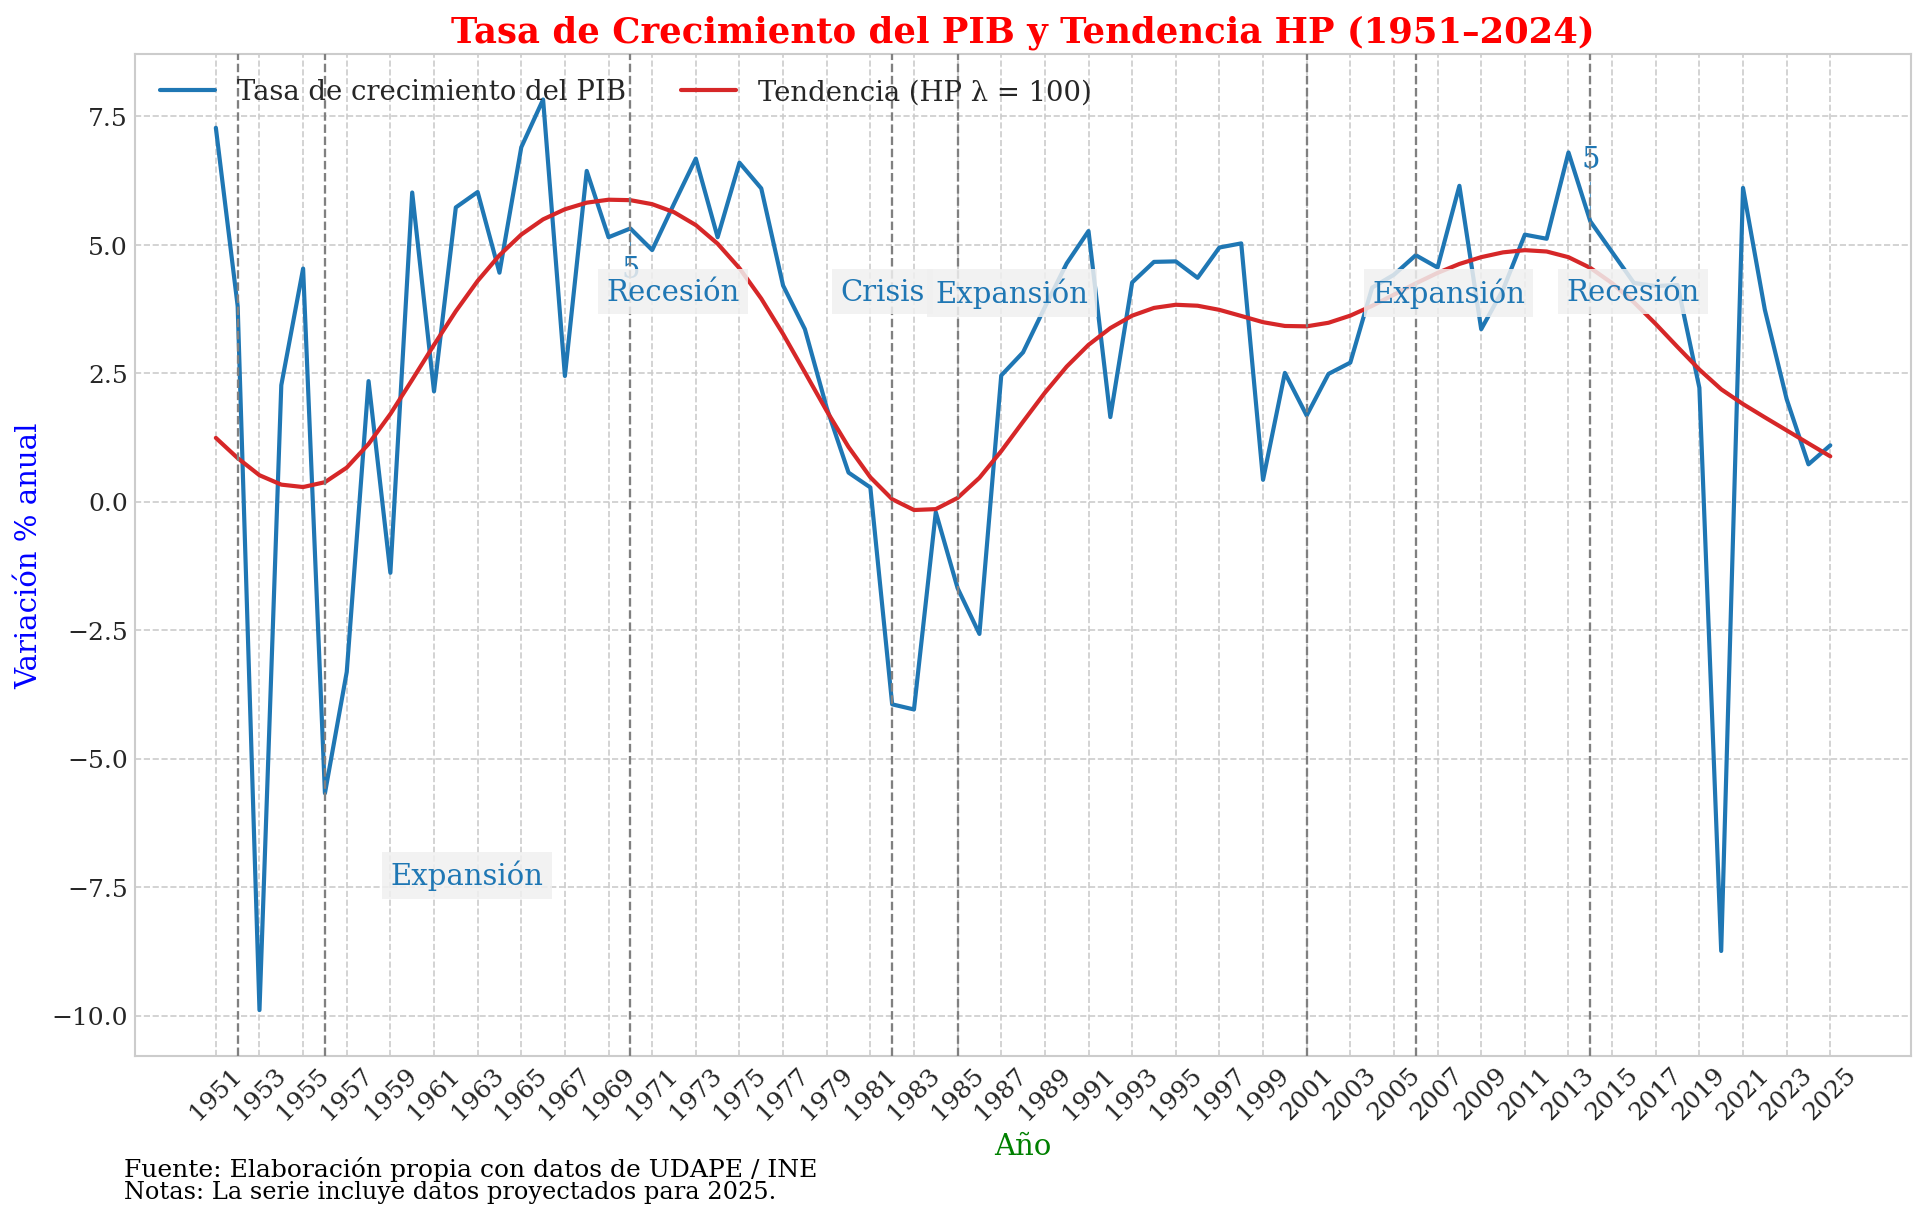

In [1]:
# ─────────────────────────────────────────────────────────────────────
# 1. Importaciones
# ─────────────────────────────────────────────────────────────────────
import sys, os, sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter

sys.path.append(os.path.abspath('../'))         # utilidades propias
from func_auxiliares.graficos_utils import (                    # funciones de plantilla
    get_df, set_style, init_base_plot,
    adjust_annot_years, add_year_value_annotations, add_hitos
)
from func_auxiliares.config import (                            # constantes globales
    ASSETS_DIR, DB_PATH,
    annot_years_sin_crisis, hitos_v
)

# ─────────────────────────────────────────────────────────────────────
# 2. Configuración general
# ─────────────────────────────────────────────────────────────────────
output_dir = ASSETS_DIR / "serie_completa" / "tasa_crecimiento_pib"
output_dir.mkdir(parents=True, exist_ok=True)
set_style()

# ─────────────────────────────────────────────────────────────────────
# 3. Carga de datos y cálculo del filtro HP
# ─────────────────────────────────────────────────────────────────────
SQL = """
    SELECT
      año,
      crecimiento
    FROM tasa_crecimiento_pib
"""
df = get_df(SQL, str(DB_PATH), index_col="año")
#fuente https://www.imf.org/en/Countries/BOL 
df.loc[2025]=1.1
_, tendencia_100 = hpfilter(df["crecimiento"], lamb=100)
df["tendencia_hp_100"] = tendencia_100
# ─────────────────────────────────────────────────────────────────────
# 4. Componentes, abreviaturas y colores
# ─────────────────────────────────────────────────────────────────────
componentes      = [
    ("crecimiento",        "Tasa de crecimiento del PIB"),
    ("tendencia_hp_100",   "Tendencia (HP λ = 100)"),
]
cols_componentes = [c for c, _ in componentes]
abbr             = {"crecimiento": "ΔPIB", "tendencia_hp_100": "Trend"}
colors           = {"crecimiento": "#1f77b4", "tendencia_hp_100": "#d62728"}

# ─────────────────────────────────────────────────────────────────────
# 5. Anotaciones y offsets
# ─────────────────────────────────────────────────────────────────────
annot_years = adjust_annot_years(df, annot_years_sin_crisis)
annotation_offsets = {
    "crecimiento": {
        1952: (0,  0.8), 1970: (0, -0.8),
        1982: (0,  1.0), 2009: (0, -1.0),
        2014: (0,  1.2), 2020: (0, -1.2),
        2024: (0,  1.2),
    },
    "tendencia_hp_100": {}          # la curva es suave; normalmente no se anota
}

# Línea vertical en hitos estándar (cambios de régimen)
hitos_offset = {
    1956: -0.8,
    1970: 0.5,
    1982: 0.5,
    1985: 0.5,
    2006: 0.5,
    2014: 0.5,
}
hitos_text_x = {
    1956: 10,
    1970: 5,
    1982: 1.5,
    1985: 6,
    2001: 2.5,
    2006: 5,
    2014: 5
}
# ─────────────────────────────────────────────────────────────────────
# 6. Generación de la gráfica
# ─────────────────────────────────────────────────────────────────────
fig, ax = init_base_plot(
    df,
    series=componentes, 
    colors=colors,
    title="Tasa de Crecimiento del PIB y Tendencia HP (1951–2024)",
    xlabel="Año",
    ylabel="Variación % anual",
    source_text="Fuente: Elaboración propia con datos de UDAPE / INE",
    notas="Notas: La serie incluye datos proyectados para 2025."
)

add_hitos(ax, df.index, hitos_v, hitos_offset,
          annotate_labels=('Crisis','Recesión', 'Expansión', 'Transición'),
          vertical_labels=False,
          hitos_x_text=hitos_text_x)

add_year_value_annotations(
    ax, df, annot_years, cols_componentes,
    annotation_offsets, colors, arrow_lw=0.4
)

fig.savefig(output_dir / "tasa_crecimiento_pib_hp.png")
plt.show()
plt.close(fig)


In [2]:
# ─────────────────────────────────────────────────────────────────────
# 3-bis. Ajuste ARIMA y pronóstico (5 años)
# ─────────────────────────────────────────────────────────────────────
from statsmodels.tsa.arima.model import ARIMA
# Si prefieres que auto-seleccione (p,d,q) usa pmdarima.auto_arima (opcional).

# 1. Asegúrate de que la serie es float y no NaN
y = df["crecimiento"].astype(float).dropna()

# 2. Ajusta un ARIMA(p,d,q).  (1,0,0) suele ser buen arranque para tasas ya estacionarias.
#    Cambia a otro orden si las ACF/PACF o el auto_arima lo sugieren.
model = ARIMA(y, order=(1,0,0))      # <-- ajusta p,d,q según tu diagnóstico
res   = model.fit()

# 3. Pronostica los próximos 5 años
n_forecast = 5
fc_obj     = res.get_forecast(steps=n_forecast)
pred       = fc_obj.predicted_mean        # vector de valores pronosticados
conf_int   = fc_obj.conf_int(alpha=0.05)  # intervalos (por si quisieras graficarlos)

# 4. Índice de años futuros
last_year      = df.index.max()
future_index   = np.arange(last_year + 1, last_year + 1 + n_forecast)

# 5. Crea la serie de pronóstico y añádela al DataFrame
df_forecast = pd.Series(pred.values, index=future_index, name="pronostico_arima")
df = pd.concat([df, df_forecast], axis=0)    # mantiene alineado el índice

# (Opcional) guarda los intervalos en el DataFrame también:
# df.loc[future_index, "arima_lower"] = conf_int.iloc[:, 0].values
# df.loc[future_index, "arima_upper"] = conf_int.iloc[:, 1].values
df

/home/navi/Desktop/archivos/DS/eco/Proyecto_macro/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/navi/Desktop/archivos/DS/eco/Proyecto_macro/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/navi/Desktop/archivos/DS/eco/Proyecto_macro/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/navi/Desktop/arc

,crecimiento,tendencia_hp_100,pronostico_arima
1951,7.28,1.245166,NaN
1952,3.81,0.851570,NaN
1953,-9.89,0.518321,NaN
1954,2.27,0.335354,NaN
1955,4.54,0.288517,NaN
...,...,...,...
2026,NaN,NaN,2.378624
2027,NaN,NaN,2.826596
2028,NaN,NaN,2.983544
2029,NaN,NaN,3.038532


NameError: name 'hitos_v_sin_crisis' is not defined

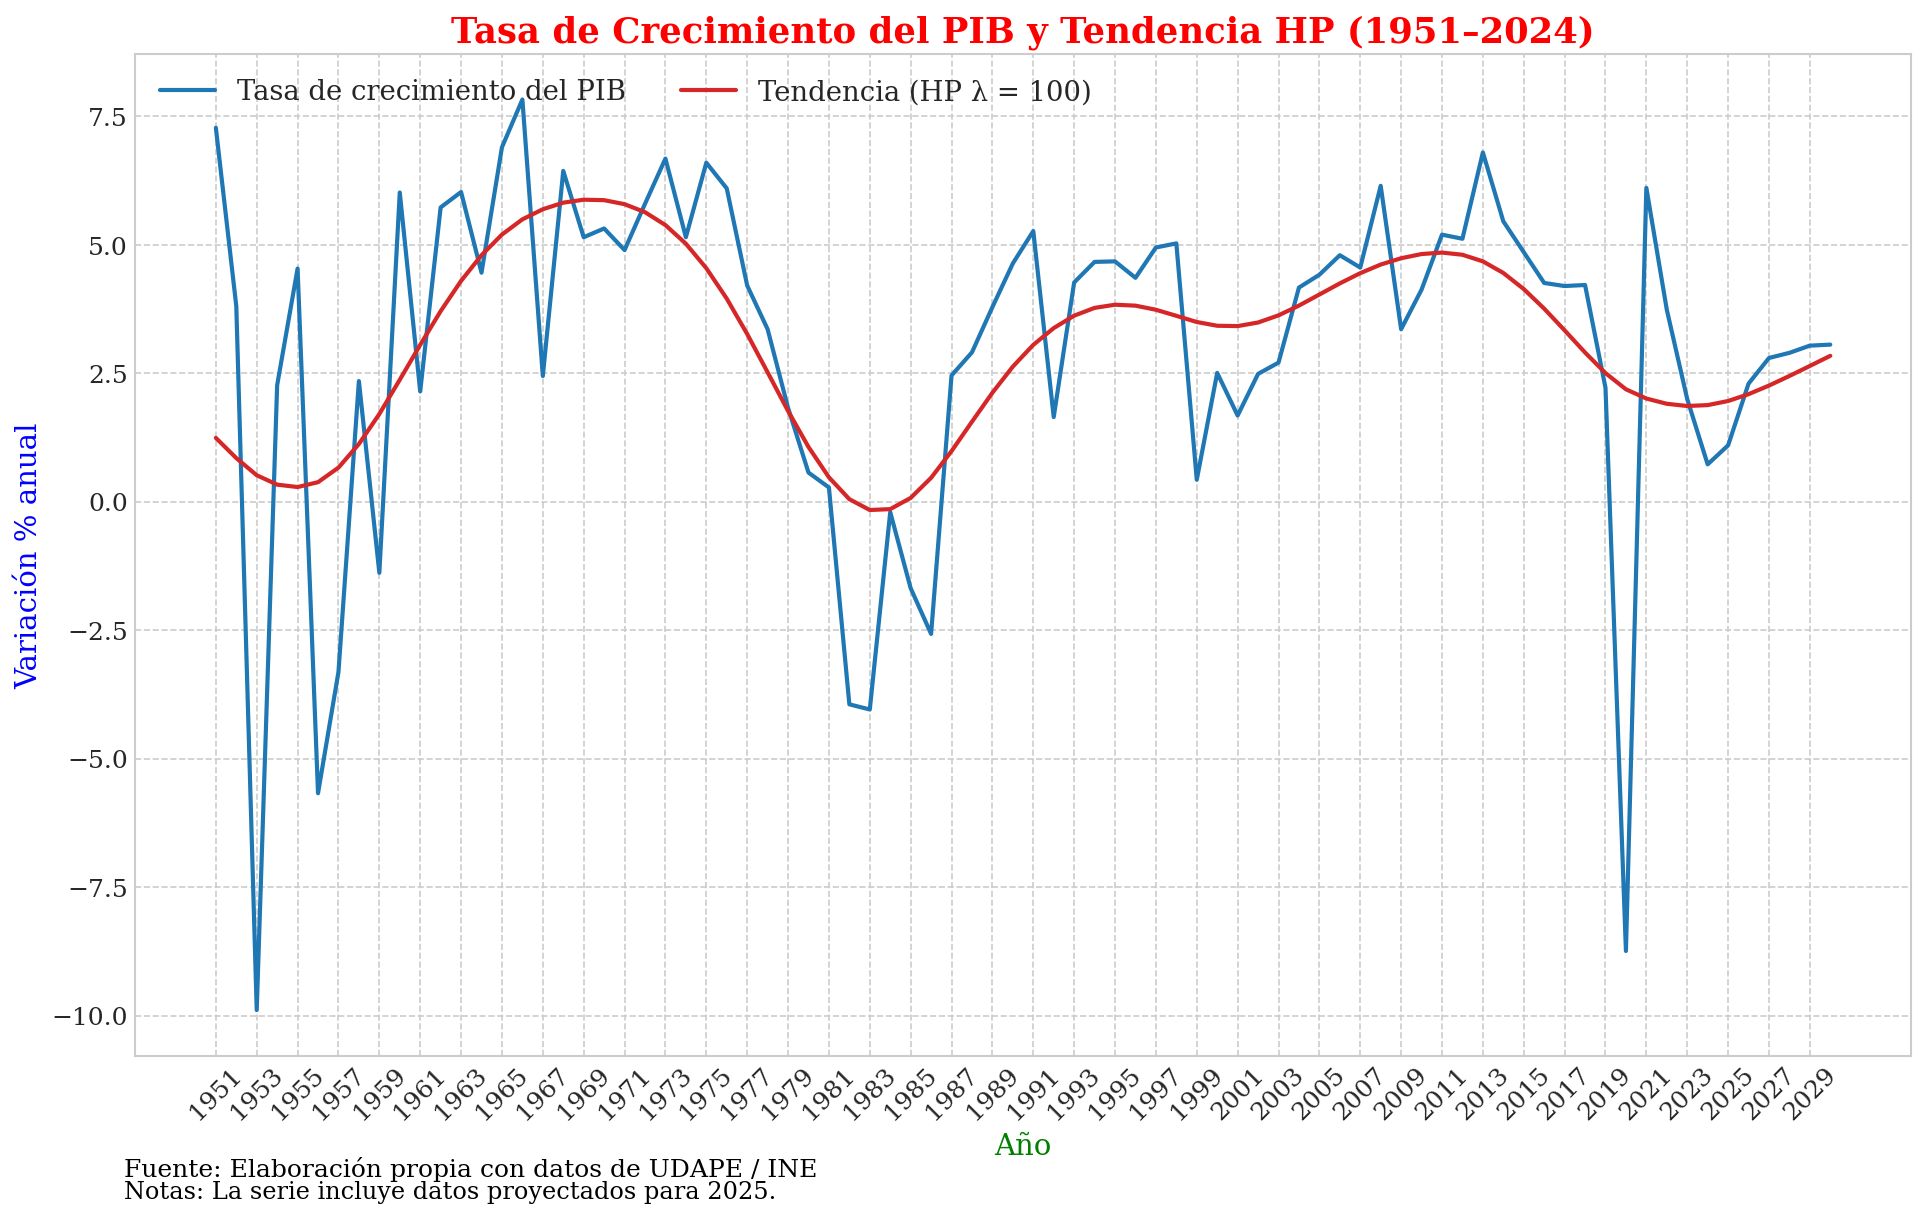

In [3]:
df2 = df.copy()
df2.loc[2026:2030, "crecimiento"]=[2.3,2.8,2.9,3.04,3.06]
_, tendencia_100 = hpfilter(df2["crecimiento"], lamb=100)
df2["tendencia_hp_100"] = tendencia_100
fig, ax = init_base_plot(
    df2,
    series=componentes,
    colors=colors,
    title="Tasa de Crecimiento del PIB y Tendencia HP (1951–2024)",
    xlabel="Año",
    ylabel="Variación % anual",
    source_text="Fuente: Elaboración propia con datos de UDAPE / INE",
    notas="Notas: La serie incluye datos proyectados para 2025."
)

add_hitos(ax, df.index, hitos_v_sin_crisis, hitos_offset)
add_year_value_annotations(
    ax, df, annot_years, cols_componentes,
    annotation_offsets, colors, arrow_lw=0.4
)


In [ ]:
df.tail(10)

,crecimiento,tendencia_hp_100,pronostico_arima
2021,6.11,1.903264,NaN
2022,3.74,1.645081,NaN
2023,2.00,1.391251,NaN
2024,0.73,1.137621,NaN
2025,1.10,0.886130,NaN
2026,NaN,NaN,2.378624
2027,NaN,NaN,2.826596
2028,NaN,NaN,2.983544
2029,NaN,NaN,3.038532
2030,NaN,NaN,3.057797
